Below is a code-completion problem for your final exam.

Let's build a variational autoencoder code that

1. loads MNIST,
2. builds a 2‑D **MLP** VAE,
3. visualises the latent space (scatter, morph‑sheet).

Use the 'scaffold' code with ### TODO markers and hints. Fill in the blanks to produce a working 2D MLP-VAE on MNIST, finish with a latent space scatter plot and a 20x2x morph sheet.

What to hand in:

- Your completed Colab notebook with ALL ### TODO filled in.
- #4 the latent scatter.
- #5 the 20×20 morph sheet.

In [2]:
import torch, numpy as np, matplotlib.pyplot as plt
# nn for layers & built-in activations; optim for optimizers like Adam
from torch import nn, optim
# datasets contains MNIST; transforms lets us convert Python image library (PIL) images → tensors
from torchvision import datasets, transforms
# DataLoader wraps a dataset and provides minibatches & shuffling
from torch.utils.data import DataLoader
from tqdm import tqdm   # progress bar in loops

# reproducibility & device selection
torch.manual_seed(5876131)  ### TODO: insert your student # as the seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# 1. DATA LOADING
# transforms.ToTensor(): converts PIL image (H×W×C) into a FloatTensor in [0,1].
transform = transforms.ToTensor()

# Download MNIST train/test splits; train=True/False toggles them
train_ds = datasets.MNIST(root='./data', train=True,  transform=transform, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader to iterate in minibatches of 128 images
# shuffle=True ensures random order each epoch
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)

Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]


**2. MLP‑VAE architecture  **

Encoder $(x\!\to\!h\!\to\!(\mu,\log\sigma^2)$)  
Decoder $(z\!\to\!\hat x$)

**Re‑parameterisation trick**

$
z \;=\; \mu + \sigma \,\varepsilon,\quad
\varepsilon\sim\mathcal N(0,I)
$

In [6]:
# 2. MLP-VAE DEFINITION
D, Z = 28*28, 2   # D = flattened pixel count; Z = latent dimension

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder network: D→256→64, then two separate heads for μ and logσ²
        self.enc = nn.Sequential(
            nn.Linear(D, 256), nn.ReLU(),
            nn.Linear(256, 64),  nn.ReLU()
        )
        # Heads produce mean and log-variance of approximate posterior q(z|x)
        self.mu, self.logvar = nn.Linear(64, Z), nn.Linear(64, Z)

        # Decoder network: Z→64→256→D, Sigmoid to map outputs back into [0,1]
        self.dec = nn.Sequential(
            nn.Linear(Z, 64),  nn.ReLU(),
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, D),  nn.Sigmoid()
        )

    @staticmethod
    def reparam(mu, logvar):
        """Re-parameterisation trick:
           z = μ + σ·ε,  where ε~N(0,I), σ=exp(0.5*logvar)
           This makes z a differentiable function of μ, logvar."""
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Flatten from (B,1,28,28) to (B, D)
        x = x.view(x.size(0), -1)
        h = self.enc(x)
        # Compute posterior parameters
        mu, logvar =self.mu(h), self.logvar(h)
        # Sample z via reparam trick
        z = self.reparam(mu, logvar)
        # Decode and reshape back to image shape
        x_hat = self.dec(z).view(-1, 1, 28, 28)
        return x_hat, mu, logvar

# ELBO = reconstruction + KL divergence
#   recon = BCE(x_hat, x);  KL = ½Σ(μ² + σ² - logσ² - 1)
def elbo(x_hat, x, mu, logvar):
    # BCE: binary cross-entropy pixel-wise
    recon = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # KL term pushes q(z|x) towards N(0,1)
    kl    = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

ELBO loss  

$$
\mathcal L =
\underbrace{\text{BCE}(x,\hat x)}_{\text{reconstruction}}
+
\underbrace{\tfrac12\!\sum(\mu^2+\sigma^2-\log\sigma^2-1)}_{\text{KL divergence}}
$$

In [7]:
# 3. TRAINING
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 10

for ep in range(epochs):
    vae.train()
    total_loss = 0.0
    for x, _ in tqdm(train_loader, desc=f'Epoch {ep+1}/{epochs}'):
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = elbo(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'ELBO ≈ {total_loss/len(train_loader.dataset):.3f}')

Epoch 1/10: 100%|██████████| 469/469 [00:06<00:00, 67.04it/s]


ELBO ≈ 197.007


Epoch 2/10: 100%|██████████| 469/469 [00:07<00:00, 66.12it/s]


ELBO ≈ 165.965


Epoch 3/10: 100%|██████████| 469/469 [00:06<00:00, 71.97it/s]


ELBO ≈ 160.464


Epoch 4/10: 100%|██████████| 469/469 [00:07<00:00, 63.52it/s]


ELBO ≈ 157.264


Epoch 5/10: 100%|██████████| 469/469 [00:07<00:00, 63.36it/s]


ELBO ≈ 155.268


Epoch 6/10: 100%|██████████| 469/469 [00:06<00:00, 69.72it/s]


ELBO ≈ 153.773


Epoch 7/10: 100%|██████████| 469/469 [00:07<00:00, 66.09it/s]


ELBO ≈ 152.384


Epoch 8/10: 100%|██████████| 469/469 [00:06<00:00, 71.60it/s]


ELBO ≈ 151.457


Epoch 9/10: 100%|██████████| 469/469 [00:07<00:00, 65.97it/s]


ELBO ≈ 150.589


Epoch 10/10: 100%|██████████| 469/469 [00:06<00:00, 71.78it/s]

ELBO ≈ 149.546


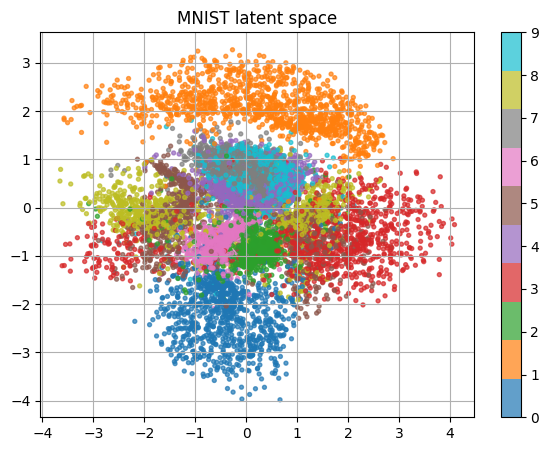

In [9]:
# 4. LATENT‐SPACE SCATTER
# Switch model to evaluation mode: disables dropout / batch-norm updates

vae.eval()    ### TODO: Why call eval() here?  Hint: inference only, no grad, no layer stats updates.
              # In evalulation mdoe BatchNorm switches to learned running statistics instead of batch specific statistics, while Dropout is disabled.
              # This helps the evaluation because all neuron contribute to prediction, and prediction are more consisttent due to stable statistics being used.

Zs, Ys = [], []
with torch.no_grad():
    for x, y in test_loader:
        x_hat, mu, logvar = vae(x.to(device))
        Zs.append(mu.cpu()); Ys.append(y)
Zs, Ys = torch.cat(Zs).numpy(), torch.cat(Ys).numpy()

plt.figure(figsize=(7,5))
plt.scatter(Zs[:,0], Zs[:,1], c=Ys, cmap='tab10', s=8, alpha=.7)
plt.colorbar(); plt.title('MNIST latent space'); plt.grid(True)
plt.show()


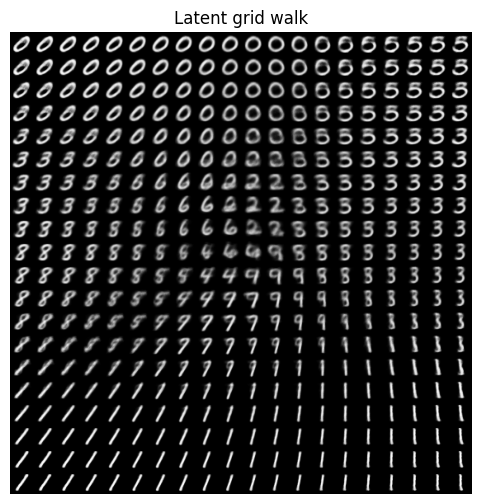

In [11]:
# 5. MORPH SHEET (20×20 GRID)
grid = torch.linspace(-3, 3, 20)
canvas = torch.zeros(28*20, 28*20)

# Again, no gradients needed
with torch.no_grad():
    for i, yi in enumerate(grid):
        for j, xi in enumerate(grid):
            # Create a 2-D latent vector on the grid, on the correct device
            z = torch.tensor([[xi, yi]], device=device)
            # Directly use the decoder to produce an image
            img = vae.dec(z)           ### TODO: why use the decoder .dec() here instead of .forward()?:
                                       # Thats why we use only the decoder part with artificially generated latent space.
                                       # We wish to control the latent space in a grid like manner so that we can plot
                                       # which 2 digits correspond would generate what image.

                                       # .forward() would take instead take an image as an input,
                                       # and encode, then decode it, which is not required for this task.

            img = img.cpu().squeeze()  # bring back to CPU and remove channel dim
            # Reshape to 28×28
            img = img.reshape(28,28)  # Hint: use .reshape or .view
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = img

plt.figure(figsize=(6,6))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title('Latent grid walk')
plt.show()